# playing around with a network
https://grand.networkmedicine.org/cell/Lung_Cancer/
cellline HCC827

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import Counter
from scipy.stats import variation
from networkx.algorithms import approximation as approx
import powerlaw
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def create_directed_graph(adj):
    """
    Create a directed graph from an adjacency matrix.
    """
    edges = adj.stack().reset_index()
    edges.columns = ['source', 'target', 'weight']
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges.values)
    del adj
    return G


In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde

def plot_degree_distribution(degrees, title, loglog=False, fit_normal=True, kde=True):
    degrees = np.array(degrees)
    degrees = degrees[degrees > 0]  # ignore zero-degree nodes (optional)

    plt.figure(figsize=(10, 6))

    # Histogram
    bins = np.logspace(np.log10(degrees.min()), np.log10(degrees.max()), 50) if loglog else 50
    plt.hist(degrees, bins=bins, density=True, alpha=0.5, label='Histogram')

    # KDE (Kernel Density Estimate)
    if kde and len(degrees) > 1:
        kde_est = gaussian_kde(degrees)
        x_vals = np.linspace(degrees.min(), degrees.max(), 500)
        plt.plot(x_vals, kde_est(x_vals), label="KDE", color="darkred")

    # Normal distribution fit (for comparison)
    if fit_normal and len(degrees) > 1:
        mu, std = norm.fit(degrees)
        x = np.linspace(degrees.min(), degrees.max(), 500)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, 'k--', linewidth=2, label=f'Normal Fit\nμ={mu:.2f}, σ={std:.2f}')

    plt.title(title)
    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, which="both", linestyle="--", alpha=0.5)

    if loglog:
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('Degree (log)')
        plt.ylabel('Density (log)')

    plt.tight_layout()
    plt.show()



def get_structure_statistics(G):
    stats = {}

    # Separate degree types for directed graphs
    in_degrees = [d for n, d in G.in_degree()]
    out_degrees = [d for n, d in G.out_degree()]
    total_degrees = [d for n, d in G.degree()]

    if len(total_degrees) == 0:
        return {
            "gini_in": 0,
            "gini_out": 0,
            "clustering": 0,
            "avg_path_length": 0,
            "powerlaw_alpha": 0,
        }

    # plot_degree_distribution(in_degrees, "In-Degree Distribution")
    # plot_degree_distribution(out_degrees, "Out-Degree Distribution")
    # plot_degree_distribution(total_degrees, "Total Degree Distribution")

    # Measure time for gini coefficient
    start_time = time.time()
    stats["gini_in"] = gini_coefficient(in_degrees)
    stats["gini_out"] = gini_coefficient(out_degrees)
    print(f"Gini coefficient calculation took {time.time() - start_time:.4f} seconds")

    # Use undirected version for clustering and path length
    G_undirected = G.to_undirected()

    # Measure time for clustering coefficient
    start_time = time.time()
    stats["clustering"] = nx.average_clustering(G_undirected)
    print(f"Clustering coefficient calculation took {time.time() - start_time:.4f} seconds")

    # Measure time for average shortest path length
    start_time = time.time()
    try:
        stats["avg_path_length"] = nx.average_shortest_path_length(G_undirected)
    except nx.NetworkXError:
        stats["avg_path_length"] = None
    print(f"Average shortest path length calculation took {time.time() - start_time:.4f} seconds")

    # Measure time for power law fit
    if len(total_degrees) >= 50:
        start_time = time.time()
        fit = powerlaw.Fit(total_degrees, verbose=False)
        stats["powerlaw_alpha"] = round(fit.power_law.alpha, 2)
        print(f"Power-law fit calculation took {time.time() - start_time:.4f} seconds")
    else:
        stats["powerlaw_alpha"] = None

    return stats


def gini_coefficient(array):
    start_time = time.time()
    array = np.array(array)
    if np.amin(array) < 0:
        array -= np.amin(array)  # shift to non-negative
    array = np.sort(array)
    n = len(array)
    if n == 0:
        return 0
    index = np.arange(1, n + 1)
    result = ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))
    print(f"Gini coefficient computation took {time.time() - start_time:.4f} seconds")
    return result

In [4]:
def print_statistics(score_dict):
    print("==========================")
    print(f"Total number of nodes: {score_dict['genes']}")
    print(f"Total number of edges: {score_dict['edges']}")

    print("\n--- Structural Properties ---")
    props = {
        "Gini coefficient (in degree)": score_dict["gini_in"],
        "Gini coefficient (out degree)": score_dict["gini_out"],
        "Avg clustering coefficient": score_dict["clustering"],
        "Avg path length": score_dict["avg_path_length"],
        "Power-law alpha (scale-free)": score_dict["powerlaw_alpha"],
    }
    for k, v in props.items():
        print(f"{k}: {round(v, 3) if isinstance(v, (float, int)) and v is not None else v}")


In [5]:
def filter_edges_by_threshold(G: nx.DiGraph, threshold):
    # Remove edges with weight less than the threshold
    edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < threshold]
    G.remove_edges_from(edges_to_remove)
    
    # Get the largest weakly connected component
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    
    # Remove nodes that are not part of the largest weakly connected component
    G.remove_nodes_from(set(G.nodes) - largest_cc)
    
    return G

In [6]:
def collect_statistics(thresholds, G, print_output=False):
    statistics_list = []

    for threshold in tqdm(thresholds):
        print(f"\n=== Filter with threshold: {threshold} ===")
        G_filtered = filter_edges_by_threshold(G, threshold)

        print("--- calculating structure statistics ---")
        statistics_list.append(get_structure_statistics(G_filtered))

    return statistics_list

In [7]:
import matplotlib.pyplot as plt

def plot_statistics_list(statistics_list, thresholds, name):
    # Create a grid of 1x2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('Graph & Experiment Statistics by Threshold', fontsize=22)

    # --- Plot 5: Clustering Coefficient & Path Length ---
    axs[0].plot(thresholds, [s["clustering"] for s in statistics_list], marker='o', label='Clustering Coeff.')
    avg_paths = [s["avg_path_length"] if s["avg_path_length"] is not None else float('nan') for s in statistics_list]
    axs[0].plot(thresholds, avg_paths, marker='o', label='Avg Path Length')
    axs[0].set_title('Small-World Properties', fontsize=14)
    axs[0].set_xlabel('Threshold')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True)

    # --- Plot 6: Gini & Power-Law Alpha ---
    axs[1].plot(thresholds, [s["gini_in"] for s in statistics_list], marker='o', label='Gini In-Degree')
    axs[1].plot(thresholds, [s["gini_out"] for s in statistics_list], marker='o', label='Gini Out-Degree')
    alphas = [s["powerlaw_alpha"] if s["powerlaw_alpha"] is not None else float('nan') for s in statistics_list]
    axs[1].plot(thresholds, alphas, marker='o', label='Power-law Alpha')
    axs[1].set_title('Scale-Free Indicators', fontsize=14)
    axs[1].set_xlabel('Threshold')
    axs[1].set_ylim(0, 4)
    axs[1].set_ylabel('Value')
    axs[1].legend()
    axs[1].grid(True)

    # Finalize
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(name + '.png', dpi=300)
    plt.show()


In [ ]:
# load the adjacency matrix
adj = pd.DataFrame(pd.read_csv('../data/A549.csv', index_col='Row'))
# load the target counts
target_counts = pd.read_csv('../data/target_counts.csv', index_col='gene_symbol')
# create the directed graph
G = create_directed_graph(adj)
# create a graph G_landmark that removes all nodes that are not listed in landmark_genes.txt
landmark_genes = pd.read_csv('../data/landmark_genes.txt', header=None)
landmark_genes = landmark_genes[0].tolist()
G_landmark = G.subgraph(landmark_genes).copy()

In [ ]:
# Set thresholds for filtering edges
thresholds = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [ ]:
# Collect statistics for each threshold
#statistics_list = collect_statistics(thresholds, G)

In [ ]:
landmark_statistics_list = collect_statistics(thresholds, G_landmark)

  0%|          | 0/15 [00:00<?, ?it/s]


=== Filter with threshold: 1 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0020 seconds
Gini coefficient computation took 0.0001 seconds
Gini coefficient calculation took 0.0022 seconds
Clustering coefficient calculation took 0.3334 seconds


  7%|▋         | 1/15 [00:02<00:28,  2.07s/it]

Average shortest path length calculation took 1.5408 seconds
Power-law fit calculation took 0.0183 seconds

=== Filter with threshold: 2 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0003 seconds
Gini coefficient computation took 0.0002 seconds
Gini coefficient calculation took 0.0005 seconds
Clustering coefficient calculation took 0.1072 seconds


 13%|█▎        | 2/15 [00:03<00:21,  1.68s/it]

Average shortest path length calculation took 1.2338 seconds
Power-law fit calculation took 0.0185 seconds

=== Filter with threshold: 3 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0002 seconds
Gini coefficient computation took 0.0002 seconds
Gini coefficient calculation took 0.0005 seconds
Clustering coefficient calculation took 0.0327 seconds


 20%|██        | 3/15 [00:04<00:14,  1.20s/it]

Average shortest path length calculation took 0.5574 seconds
Power-law fit calculation took 0.0087 seconds

=== Filter with threshold: 4 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0002 seconds
Gini coefficient computation took 0.0001 seconds
Gini coefficient calculation took 0.0003 seconds
Clustering coefficient calculation took 0.0117 seconds


 40%|████      | 6/15 [00:04<00:03,  2.38it/s]/tmp/ipykernel_39919/226394959.py:112: RuntimeWarning: invalid value encountered in scalar divide
  result = ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))
100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

Average shortest path length calculation took 0.2206 seconds
Power-law fit calculation took 0.0117 seconds

=== Filter with threshold: 5 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0002 seconds
Gini coefficient computation took 0.0001 seconds
Gini coefficient calculation took 0.0004 seconds
Clustering coefficient calculation took 0.0071 seconds
Average shortest path length calculation took 0.0758 seconds
Power-law fit calculation took 0.0057 seconds

=== Filter with threshold: 6 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0003 seconds
Gini coefficient computation took 0.0001 seconds
Gini coefficient calculation took 0.0006 seconds
Clustering coefficient calculation took 0.0011 seconds
Average shortest path length calculation took 0.0039 seconds

=== Filter with threshold: 7 ===
--- calculating structure statistics ---
Gini coefficient computation took 0.0003 seconds
Gini coefficient computation took 0.0001 second

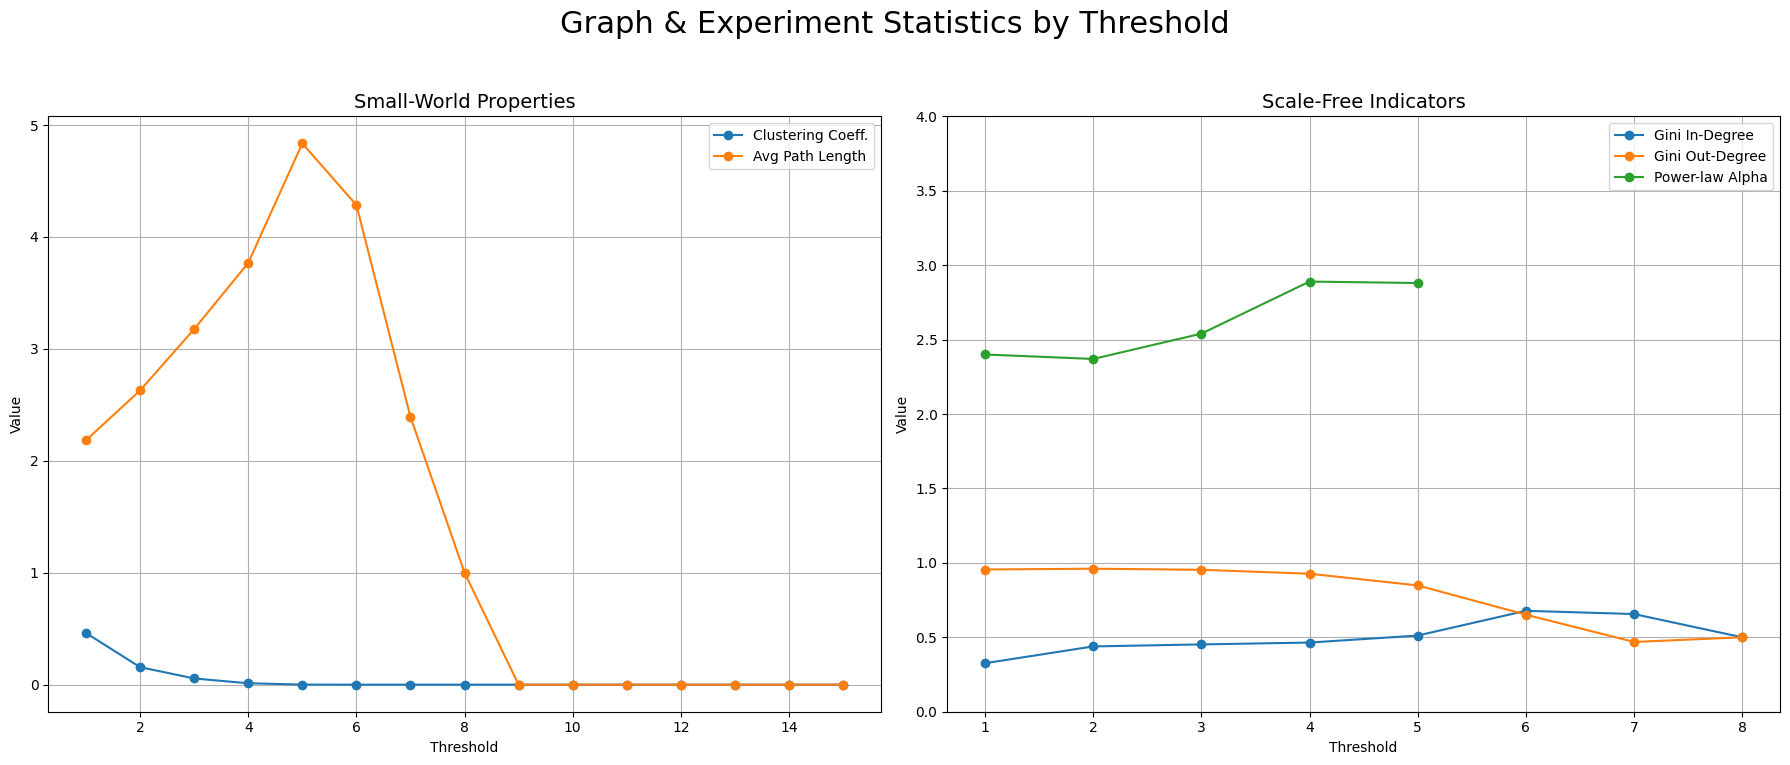

In [ ]:
plot_statistics_list(landmark_statistics_list, thresholds, 'total_statistics')

  0%|          | 0/2 [00:00<?, ?it/s]


=== Filter with threshold: 14 ===
